In the last post, we looked at variational principles by studying the minimal surface equation.
Much of what you learn in multivariable calculus carries over equally well to infinite-dimensional spaces and we were able to leverage a lot of this intuition to design efficient solution procedures.
For example, the notion of convexity carries over to variatonal problems and using this idea we can show that Newton's method is effective in this setting as well.

When we solved the minimal surface equation, our solution space consists of all functions that satisfy a set of Dirichlet boundary conditions.
These conditions are easy to eliminate so our problem is essentially unconstrained.
In this post, we'll look at the Stokes equations, which are a *constrained* optimization problem.
For unconstrained problems, the convexity of the objective implies a kind of stability property that we can use to prove that roughly any finite element basis will give a convergent approximation scheme.
For constrained problems we have to be much more careful about the choice of basis and this is the content of the *Ladyzhenskaya-Babuška-Brezzi* or LBB conditions, which I'll describe in a later post.
For now, we'll focus on solving the Stokes equations using one particular discretization, the Taylor-Hood element.

The Stokes equations describe slow flow of very viscous, incompressible fluids.
The fields we're solving for are the velocity $u$ and the pressure $p$.
The incompressibility condition means that the velocity field is divergence-free:

$$\nabla\cdot u = 0.$$

The remaining equations state that the stresses are in balance wth body forces:

$$\nabla\cdot \tau - \nabla p + f = 0,$$

where $\tau$ is the rank-2 stress tensor and $f$ are the body forces.
The stress tensor must be related somehow to the velocity field.
For a viscous fluid, the stress tensor is related to the *rate-of-strain* tensor

$$\dot\varepsilon = \frac{1}{2}\left(\nabla u + \nabla u^*\right).$$

(For solids the stress tensor is related to the gradient of the displacement rather than the velocity.)
The simplest constitutive relation is that of a Newtonian fluid:

$$\tau = 2\mu\dot\varepsilon,$$

where $\mu$ is the viscosity.
There are other nonlinear constitutive relations, but for now we'll just consider Newtonian fluids.
If $U$ and $L$ are characteristic velocity and length scales for the particular flow at hand and $\rho$ is the fluid density, the Stokes equations are a good description when the *Reynolds number* is much less than 1:

$$\text{Re} \equiv \frac{\rho UL}{\mu} \ll 1.$$

When the Reynolds number is closer to or larger than 1, we need to use the full Navier-Stokes equations, which includes inertial effects as well.

The Stokes equations, like the Poisson equation, have a minimization principle, but for two fields instead of one.
The variational principle is that the solution $u$, $p$ is a critical point of the rate of decrease of the *Gibbs free energy*:

$$\dot{\mathscr{G}}(u, p) = \int_\Omega\left(\mu|\dot\varepsilon(u)|^2 - p\nabla\cdot u - f\cdot u\right)dx.$$

You can show using the usual tricks that the Euler-Lagrange equations for this functional are the Stokes equations.
The free energy dissipation functional consists of a positive, quadratic term in the velocity, but the pressure $p$ only acts like a Lagrange multiplier enforcing the incompressibility condition.
The lack of any positivity in the pressure is part of what makes the Stokes equations so challenging to discretize and solve.
While the second derivative of the objective is still symmetric, it is no longer positive-definite.

### Demonstration

Here we'll work on a classic problem of flow driven by a moving boundary.
The domain will consist of a circle with two holes removed.
We'll imagine that these holes are cylindrical turbines that are rotating with some fixed speed and dragging the fluid along with them.
As we'll see, getting a linear solver to converge for this problem is much more challenging than for the Poisson equation.

In [1]:
import numpy as np
from numpy import pi as π
def add_ellipse(geometry, x, y, a, b, N, lcar):
    θs = np.array([2 * π * n / N for n in range(N)])
    xs, ys = x + a * np.cos(θs), y + b * np.sin(θs)
    points = [geometry.add_point([x, y, 0], lcar=lcar) for x, y in zip(xs, ys)]
    lines = [geometry.add_line(points[n], points[(n + 1) % N])
             for n in range(N)]

    geometry.add_physical(lines)
    line_loop = geometry.add_line_loop(lines)
    return line_loop

In [2]:
import pygmsh
geometry = pygmsh.built_in.Geometry()

outer_line_loop = add_ellipse(geometry, x=0, y=0, a=1, b=1, N=128, lcar=1/4)
inner_loops = [
    add_ellipse(geometry, x=0, y=+1/2, a=1/8, b=1/8, N=64, lcar=1/4),
    add_ellipse(geometry, x=0, y=-1/2, a=1/8, b=1/8, N=64, lcar=1/4)
]

plane_surface = geometry.add_plane_surface(outer_line_loop, inner_loops)
geometry.add_physical(plane_surface)

with open('mixer.geo', 'w') as geo_file:
    geo_file.write(geometry.get_code())
    
!gmsh -2 -format msh2 -v 0 -o mixer.msh mixer.geo

In [3]:
import firedrake
mesh = firedrake.Mesh('mixer.msh')

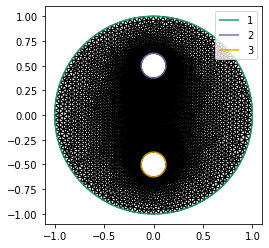

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.set_aspect('equal')
firedrake.triplot(mesh, axes=axes)
axes.legend();

For this problem we'll use the *Taylor-Hood* element: piecewise linear basis functions for the pressure and piecewise quadratic basis functions for the velocity.
The Taylor-Hood element is stable for the Stokes equations in that norm of the inverse of the disretized linear system is bounded as the mesh is refined.
This is a very special property and not just any element will work.

For scalar problems, the solution is a single field, but for the Stokes equations our solution consists of a pair of a velocity and a pressure field.
Firedrake includes a handy algebraic notation for defining the direct product of two function spaces.

In [5]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=1)
V = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2)
Z = V * Q

We can access the components of a function that lives in this product space using the usual Python indexing operators, but it's more convenient to use the function `firedrake.split` to give us handles for the two components.

In [6]:
z = firedrake.Function(Z)
u, p = firedrake.split(z)

This way our code to define the objective functional looks as much like the math as possible, rather than have to constantly reference the components.

We'll use a viscosity coefficient $\mu$ of 1000.
Since the diameter of the domain and the fluid velocity are both on the order of 1, the viscosity would need to be fairly large for the Stokes equations to actually be applicable.

In [7]:
from firedrake import inner, sym, grad, div, dx
def ε(u):
    return sym(grad(u))

μ = firedrake.Constant(1e3)
𝒢̇ = (μ * inner(ε(u), ε(u)) - p * div(u)) * dx

One of the extra challenging factors about the Stokes equations is that they have a non-trivial null space.
To see this, suppose we have some velocity-pressure pair $u$, $p$.
The velocity field $u$ is not necessarily divergence-free, but we do need that $u\cdot n = 0$ on the boundary of the domain.
If we add a constant factor $p_0$ to the pressure, then the value of the objective functional is unchanged:

$$\begin{align}
\dot{\mathscr{G}}(u, p) - \dot{\mathscr{G}}(u, p + p_0) & = \int_\Omega p_0\nabla\cdot u\, dx \\
& = p_0\int_{\partial\Omega}u\cdot n\, ds = 0.
\end{align}$$

In order to obtain a unique solution to the system, we can impose the additional constraint that

$$\int_\Omega p\, dx = 0,$$

or in other words that the pressure must be orthogonal to all the constant functions.

In [8]:
from firedrake import MixedVectorSpaceBasis, VectorSpaceBasis
basis = VectorSpaceBasis(constant=True)
nullspace = MixedVectorSpaceBasis(Z, [Z.sub(0), basis])

Next we have to create the boundary conditions.
The only extra work we have to do here is to get the right component of the mixed function space $Z$.

In [9]:
x = firedrake.SpatialCoordinate(mesh)

x2 = firedrake.as_vector((0, +1/2))
r2 = firedrake.Constant(1/8)
x3 = firedrake.as_vector((0, -1/2))
r3 = firedrake.Constant(1/8)

q2 = (x - x2) / r2
q3 = (x - x3) / r3

u2 = firedrake.as_vector((-q2[1], q2[0]))
u3 = firedrake.as_vector((-q3[1], q3[0]))

from firedrake import DirichletBC, as_vector
bc1 = DirichletBC(Z.sub(0), as_vector((0, 0)), 1)
bc2 = DirichletBC(Z.sub(0), u2, 2)
bc3 = DirichletBC(Z.sub(0), u3, 3)

Now let's see what happens if we invoke the default linear solver.

In [10]:
from firedrake import derivative

try:
    firedrake.solve(
        derivative(𝒢̇, z) == 0, z,
        bcs=[bc1, bc2, bc3],
        nullspace=nullspace
    )
except firedrake.ConvergenceError:
    print("Oh heavens, it didn't converge!")

We'll take the easy way out and use the sparse direct solver [MUMPS](http://mumps-solver.org/) to make sure we get an answer.
This approach will work for now, but even parallel direct solvers scale poorly to large problems, especially in 3D.
The proper incanctation to invoke the direct solver needs a bit of explaining.
For mixed problems like the Stokes equations, Firedrake will assemble a special matrix type that exploits the problem's block structure.
Unfortunately MUMPS can't work with this matrix format, so we have to specify that it will use PETSc's [aij](https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/Mat/MATSEQAIJ.html#MATSEQAIJ) matrix format with the option `'mat_type': 'aij'`.
Next, we'll request that the solver use the LU factorization with `'pc_type': 'lu'`.
Without any other options, this will use PETSc's built-in matrix factorization routines.
These are fine for strictly positive matrices, but fail when the problem has a non-trivial null space.
The option `'pc_factor_mat_solver_type': 'mumps'` will use the MUMPS package instead of PETSc's built-in sparse direct solver.

In [11]:
firedrake.solve(
    derivative(𝒢̇, z) == 0, z,
    bcs=[bc1, bc2, bc3],
    nullspace=nullspace,
    solver_parameters={
        'mat_type': 'aij',
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
)

Some cool features you can observe in the stream plot are the saddle point at the center of the domain and the two counter-rotating vortices that form on either side of it.

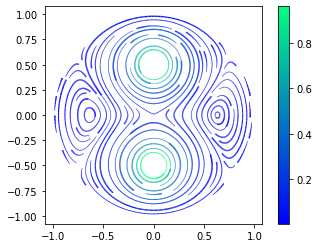

In [12]:
u, p = z.split()
fig, axes = plt.subplots()
axes.set_aspect('equal')
kwargs = {'resolution': 1/30, 'seed': 4, 'cmap': 'winter'}
streamlines = firedrake.streamplot(u, axes=axes, **kwargs)
fig.colorbar(streamlines);

The velocity field should be close to divergence-free; if we project the divergence into a DG(2) we can see what the exact value is.
There are some small deviations, especially around the boundary of the domain.
Part of the problem is that the boundary conditions we've specified are exactly tangent to the idealized domain -- a large circle with two circular holes punched out of it -- but not to its discrete approximation by a collection of straight edges.

In [13]:
S = firedrake.FunctionSpace(mesh, family='DG', degree=2)
div_u = firedrake.project(div(u), S)

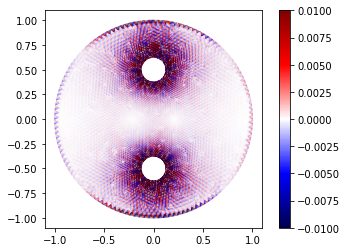

In [14]:
fig, axes = plt.subplots()
axes.set_aspect('equal')
kwargs = {'vmin': -0.01, 'vmax': +0.01, 'cmap': 'seismic'}
triangles = firedrake.tripcolor(div_u, axes=axes, **kwargs)
fig.colorbar(triangles);

For now we'll calculate and store the norm of the velocity diverence.
When we try to improve on this we'll use this value as a baseline.

In [15]:
linear_coords_divergence = firedrake.norm(div_u)
print(linear_coords_divergence)

0.026532615307004404


### Higher-order geometries

We can try to improve on this by using curved edges for the geometry instead of straight ones.
The topology of the mesh is the same; we're just adding more data describing how it's embedded into Euclidean space.
In principle, gmsh can generate this for us, but reading in the file seems to be [awfully annoying](https://lists.mcs.anl.gov/pipermail/petsc-dev/2017-June/020972.html).
To get a higher-order geometry, we'll proceed by:

1. making a quadratic vector function space
2. interpolating the linear coordinates into this space
3. patching the new coordinate field to conform to the boundary

This approach will work for our specific problem but it requires us to know things about the idealized geometry that aren't always available.
So what we're about to do isn't exactly generalizable.

To do the patching in step 3, we'll create boundary condition objects defined on the quadratic function space and then apply them.
We need to know the numbering of the various boundary segments in order to do that, so to refresh the memory let's look at the mesh again.

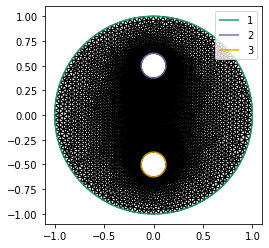

In [16]:
fig, axes = plt.subplots()
axes.set_aspect('equal')
firedrake.triplot(mesh, axes=axes)
axes.legend();

The outer curve is boundary 1, the upper mixer head is boundary 2, and the lower head is boundary 3.
With that in mind we can create the new coordinate field.

In [17]:
Vc = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2)

In [18]:
from firedrake import sqrt, Constant
def fixup(x, center, radius):
    distance = sqrt(inner(x - center, x - center))
    return center + radius * (x - center) / distance

centers = [Constant((0., 0.)), Constant((0., +.5)), Constant((0., -0.5))]
radii = [Constant(1.), Constant(1/8), Constant(1/8)]
bcs = [firedrake.DirichletBC(Vc, fixup(x, center, radius), index + 1)
       for index, (center, radius) in enumerate(zip(centers, radii))]

X0 = firedrake.interpolate(mesh.coordinates, Vc)
X = X0.copy(deepcopy=True)
for bc in bcs:
    bc.apply(X)

Just as a sanity check, we'll calculate the average deviation of the new from the old coordinate field to see how different they are.

In [19]:
from firedrake import ds
length = firedrake.assemble(Constant(1.) * ds(mesh))
firedrake.assemble(sqrt(inner(X - X0, X - X0)) * ds) / length

0.000180710597501049

Now we can solve the Stokes equations again on this new mesh using the exact same procedures as before.

In [20]:
qmesh = firedrake.Mesh(X)
Q = firedrake.FunctionSpace(qmesh, family='CG', degree=1)
V = firedrake.VectorFunctionSpace(qmesh, family='CG', degree=2)
Z = V * Q

z = firedrake.Function(Z)
u, p = firedrake.split(z)

𝒢̇ = (μ * inner(ε(u), ε(u)) - p * div(u)) * dx

basis = VectorSpaceBasis(constant=True)
nullspace = MixedVectorSpaceBasis(Z, [Z.sub(0), basis])

x = firedrake.SpatialCoordinate(qmesh)

x2 = firedrake.as_vector((0, +1/2))
r2 = firedrake.Constant(1/8)
x3 = firedrake.as_vector((0, -1/2))
r3 = firedrake.Constant(1/8)

q2 = (x - x2) / r2
q3 = (x - x3) / r3

u2 = firedrake.as_vector((-q2[1], q2[0]))
u3 = firedrake.as_vector((-q3[1], q3[0]))

from firedrake import DirichletBC, as_vector
bc1 = DirichletBC(Z.sub(0), as_vector((0, 0)), 1)
bc2 = DirichletBC(Z.sub(0), u2, 2)
bc3 = DirichletBC(Z.sub(0), u3, 3)

firedrake.solve(
    derivative(𝒢̇, z) == 0, z,
    bcs=[bc1, bc2, bc3],
    nullspace=nullspace,
    solver_parameters={
        'mat_type': 'aij',
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
)

In [21]:
S = firedrake.FunctionSpace(qmesh, family='DG', degree=2)
div_u = firedrake.project(div(u), S)

The ring of spurious divergences around the outer edge of the domain is substantially reduced with curved elements.
Nonetheless, the boundary doesn't perfectly fit the circle and this imperfection means that at some points around the edge the discretized velocity field will have an unphysical, non-zero normal component.

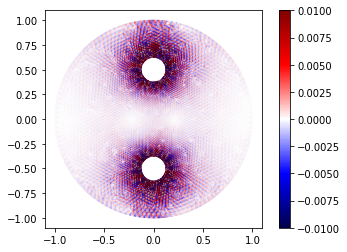

In [22]:
fig, axes = plt.subplots()
axes.set_aspect('equal')
triangles = firedrake.tripcolor(div_u, axes=axes, **kwargs)
fig.colorbar(triangles);

Using a higher-order geometry reduced the norm of the velocity divergence almost by a factor of 4, which is a big improvement.

In [23]:
quadratic_coords_divergence = firedrake.norm(div_u)
print(linear_coords_divergence / quadratic_coords_divergence)

3.6951400937053247


### Conclusion

The code above shows how to get an exact (up to rounding-error) solution to the discretized Stokes equations using MUMPS.
For larger problems in 3D, using a direct method can become prohibitively expensive.
The Firedrake documentation has a [demo](https://firedrakeproject.org/demos/stokes.py.html) of how to use PETSc's *field split* preconditioners, together with matrix-free operators, to solve the Stokes equations efficiently.
In subsequent posts, I'll show more about stable discretizations of mixed problems, and how to solve the Stokes equations with more exotic boundary conditions than the standard ones we've shown here.

The velocity field we calculated was not exactly divergence-free and part of this was a consequence of using a boundary condition that adapted poorly to a piecewise-linear discretized geometry.
We were able to do better by increasing the polynomial degree of the geometry, and in general this is absolutely necessary to achieve the expected rates of convergence with higher-order finite element bases.
Nonetheless, the support for higher-order geometries in common finite element and mesh generation packages should be better given how useful they are.
I think this is an area where a little investment in resources could make a really outsized difference.
The logical endpoint of this line of thinking is [isogeometric analysis](https://en.wikipedia.org/wiki/Isogeometric_analysis), which is an active area of research.